Copyright **`(c)`** 2023 Arman Behkish `<arman.behkish@studenti.polito.it>`  
Free for personal or classroom use.

# LAB9 - v1.13

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

In [105]:
from random import choices
from random import choices, randint, random, uniform
from functools import reduce
from operator import or_
import lab9_lib
import pprint
import numpy as np
import sys
import matplotlib.pyplot as plt

import lab9_lib

In [106]:
problem_number = 5
fitness = lab9_lib.make_problem(problem_number)

In [107]:
# CONSTANTS
ghad = 1000
population_size = 1000
offspring_size = 500
generations = 200
k = 100  # Parent selection tournament size
s = 10  # Survival selection tournament size
to_kill = 1000  # Number to kill in each survival selection
n = 1  # Number of types of crossover (1 to 9)
M = 3  # Number of iterations to change probs
sigma = 0.8 # variance for guassian mutation of probs

fitness_memory = {}
valhala = []
fit_hist = []


0.31269
0.31269
0.3158
0.3158
0.31591
0.31591
0.31623
0.31645
0.31645
0.31645999999999996
0.31945999999999997
0.32258
0.32258
0.32258
0.32268
0.32268
0.32288
0.32299
0.323
0.323
0.323
0.3231
0.3231
0.3231
0.3231
current max is stall at 0.3231 ... updating probabilities!
0.32311
0.32311
0.32311
0.32312
0.32612
0.32612
0.32612
0.32612
current max is stall at 0.32612 ... updating probabilities!
0.32612
0.32612
0.32612
current max is stall at 0.32612 ... updating probabilities!
0.32612
0.32612
0.32612
current max is stall at 0.32612 ... updating probabilities!
0.32612
0.32612
0.32622
0.32622
0.32622
0.32632
0.32632
0.32632
0.32644
0.32644
0.32644
0.32644
current max is stall at 0.32644 ... updating probabilities!
0.32644
0.32644
0.32644
current max is stall at 0.32644 ... updating probabilities!
0.32644
0.32644
0.32644
current max is stall at 0.32644 ... updating probabilities!
0.32644
0.32644
0.32644
current max is stall at 0.32644 ... updating probabilities!
0.32644
0.32644
0.32644
curre

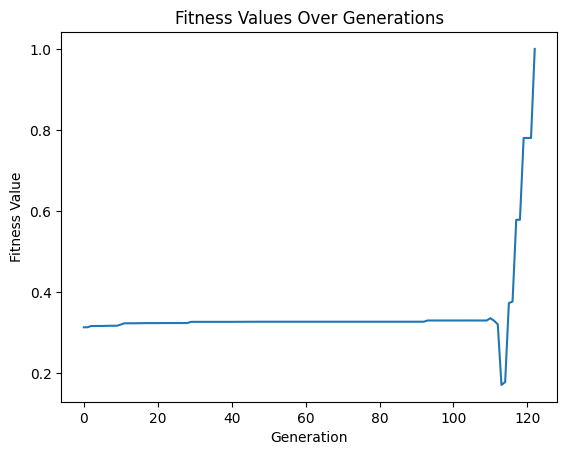

In [108]:
# Renormalize the probability distribution
def renormalize(probs):
    total = sum(probs)
    return [p / total for p in probs]


# Mutate probabilities
def mutate_probs(probs):
    m_index = np.random.choice(len(probs),1)
    probs[m_index[0]] += np.random.normal(0, sigma)
    probs[m_index[0]] = max(probs[m_index[0]] ,0)
    return(renormalize(probs))


# Function to generate the initial population
def generate(population_size):
    '''generate initial population and save their fitness'''
    population = [choices([0, 1], k=ghad) for _ in range(population_size)]
    for ind in population:
        fitness_memory[tuple(ind)] = fitness(ind)
    return population
    
# Print the individual
def print_individual(*inds):
    for ind in inds:
        print(f"{''.join(str(x) for x in ind)}: \n {get_fitness(ind):.2%}")

# Mutation
def mutate(ind):
    number_bit_mutate = 5
    for _ in range(number_bit_mutate): 
        index = randint(0, len(ind) - 1)  
        ind[index] = 1 - ind[index]  
    return ind

# Uniform crossover
def uniform_crossover(ind1, ind2):
    '''each bit from one parent'''
    return [ind1[i] if i % 2 == 0 else ind2[i] for i in range(len(ind1))]

# OR crossover
def or_crossover(ind1, ind2):
    return [reduce(or_, pair) for pair in zip(ind1, ind2)]

# n-cut crossover function
def n_cut_crossover(ind1, ind2, n):
    '''it cuts the individuals into n slices and take each slice from one indvidual to get the offspring'''
    n = n - 1
    cuts = sorted([randint(1, len(ind1) - 1) for _ in range(n)])
    slices1 = [ind1[i:j] for i, j in zip([0] + cuts, cuts + [None])]
    slices2 = [ind2[i:j] for i, j in zip([0] + cuts, cuts + [None])]
    offspring=[]
    for i in range(n + 1):
        offspring += slices1[i] if i % 2 == 0 else slices2[i]
    return offspring

# call fitness only if not in memory
def get_fitness(ind):
    if tuple(ind) in fitness_memory.keys():
        #print("from memory")
        return fitness_memory[tuple(ind)]
    else:
        #print("calling fitness")
        return fitness(ind)

# print best results
def print_info():
    print(f"maximum fitness achieved for the problem {problem_number} is {max(fit_hist)}")
    print(f"the number of fitness calls for the problem number {problem_number} were {fitness.calls}")


# Main evolutionary loop
########################

probs = [random() for _ in range(3+n)]  # Probabilities for genetic operators
probs = renormalize(probs)

population = generate(population_size)
max_fitness = 0
unchanged_fitness_count = 0

for _ in range(generations):

    for ind in valhala:
        if tuple(ind) not in fitness_memory.keys():
            fitness_memory[tuple(ind)] = fitness(ind)
    population.extend(valhala)
    valhala = []

    # Parent selection and genetic operations
    for _ in range(offspring_size):
        tournament = choices(population, k=k)
        # 0 to n-1
        chosen_operator = np.random.choice(len(probs),1, p=probs)[0]
        #best_individual = max(tournament, key=lambda ind: get_fitness(ind))
        best_individual = max(population, key=lambda ind: get_fitness(ind))
        valhala.append(best_individual)

        if chosen_operator == 0:  # Mutation
            best_individual = max(tournament, key=lambda ind: get_fitness(ind))
            offspring = [mutate(best_individual)]
        else:  # Crossover
            best_individuals = sorted(tournament, key=lambda ind: get_fitness(ind), reverse=True)[:2]
            if chosen_operator == 1:
                offspring = [uniform_crossover(*best_individuals)]
            elif chosen_operator == 2:
                offspring = [or_crossover(*best_individuals)]
            else:
                offspring = [n_cut_crossover(*best_individuals, chosen_operator - 1)]
        # Add offspring to the pool
        for ind in offspring:
            if tuple(ind) not in fitness_memory.keys():
                fitness_memory[tuple(ind)] = fitness(ind)
        population.extend(offspring)



    #Survival selection
    #for _ in range(int(kill_size/to_kill)):
        #'''in each rounds does a tournoment and remove worsts of the tournoument'''
        # tournament = choices(population, k=s)
        # tournament_fitness = [(ind,get_fitness(ind)) for ind in tournament]
        # to_remove = sorted(tournament_fitness, key=lambda x: x[1])[:to_kill]
        # population = [ind for ind in population if tuple(ind) not in {tuple(tr[0]) for tr in to_remove}]


    pop_fitness = [(ind,get_fitness(ind)) for ind in population]
    to_keep = sorted(pop_fitness, key=lambda x: x[1])[to_kill:]
    population = [ind[0] for ind in to_keep]
    #print(f"population size is: {len(population)}")


    # Checking fitness improvement
    current_max = max([get_fitness(ind) for ind in population])
    fit_hist.append(current_max)
    print(current_max)
    if current_max == 1:
        break
    if current_max > max_fitness:
        max_fitness = current_max
        unchanged_fitness_count = 0
    else:
        unchanged_fitness_count += 1

    if unchanged_fitness_count >= M:
        probs = mutate_probs(probs)
        print(f"current max is stall at {current_max} ... updating probabilities!")
        unchanged_fitness_count = 0





print_info()
plt.plot(fit_hist)
plt.title("Fitness Values Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.show()



